In [1]:
import numpy as np
%matplotlib inline
%pylab inline
import matplotlib.pyplot as plt
import sys, time
from IPython.display import clear_output, display
from matplotlib import animation
from JSAnimation import IPython_display
from JSAnimation import HTMLWriter

Populating the interactive namespace from numpy and matplotlib


# Numerical resolution of KdV equation using a Finite Volume method

## Model : Korteweg - de Vries (KdV) equation :

We will compute an approximate solution to the KdV equation, which models a wave propagation accpounting for nonlinear ansd dispersive effects : 

\begin{equation}
\begin{cases}
    u_t + au_x + b(u^2)_x + u_{xxx} = 0 \ , \ \ x \in [x_{min},x_{max}], \ \ t \in [0, t_{max}] \\
    u(x,0) = \Phi(x)
\end{cases}
\end{equation}

The constant coefficients $a$ and $b$ were introduced in order to analyze the influence of the phenomena acting in the model (pure advrection, nonlinearity and diffusion).

The kdV equation will be split in two equations, leading to the resolution of the following problem in each time step: 

\begin{equation}
\begin{cases}
    v_t + av_x + b(v^2)_x = 0 \ \ ,\ t \in [t_n,t_{n+1}], \  v(t_n) = u(t_n) \\
    w_t + w_{xxx} = 0 \ \ , \ t \in [t_n,t_{n+1}], \  w(t_n) = v(t_{n+1}) \\
    u(t_{n+1}) = v(t_{n+1})
\end{cases}
\end{equation}

## First equation
$ v_t + f(v)_x = 0, \ \ f(v) = av + bv^2 $


### Temporal discretization

#### Euler
$v_i^{n+1} = v_i^n - \Delta t  \  f(v_i^n)_x$

#### 4th order Runge-Kutta
\begin{equation}
\begin{cases}
k_1 = - f(v_i^n)_x \\
k_2 = - f\left(v_i^n + k_1\frac{\Delta t }{2}\right)_x \\
k_3 = - f\left(v_i^n + k_2\frac{\Delta t }{2}\right)_x \\
k_4 = - f(v_i^n + k_3 \Delta t)_x \\
v_i^{n+1} = v_i^n + \frac{\Delta t}{6}(k_1 + 2k_2 + 2k_3 + k_4)
\end{cases}
\end{equation}



### Spatial discretization
$ f(v_i^n)_x = \frac{f\left(v_{i+1/2}^n\right) - f\left(v_{i-1/2}^n\right)}{\Delta x}$


### Choice of the steps
In the non-conservative form, the equation is written as

$v_t +  (1+2v)v_x = 0$

which configures an advection problem with velocity $1+2v$

The space and time steps must verify the CFL condition : 

$(a+2bv)\frac{\Delta t}{\Delta x} \leq 1$

in order to avoid non-physical behaviours (e.g. mass increasing). Thereforem for each time step, we will chose, for small $\epsilon$

$\Delta t = \frac{\Delta x}{a+2b\max\limits_{x}|v|} - \epsilon$





### Evaluation of the solution on cell interfaces : resolution of the Riemann problem
In each interface between two cells of the discrete domain, the follozing Riemann problem will be solved :

\begin{equation}
\begin{cases}
v_t + f(v)_x = 0 \\
v(x,0) = v^- \ , \ x < 0 \\
v(x,0) = v^+ \ , \ x > 0
\end{cases}
\end{equation}

where the boundary is located at $x=0$ and $v^-$ and $v^+$ are the solutions in its two neighbour cells.

The flux function $f$ is uniformly convex, so the Riemann problem has a unique weak, admissible solution (REFERENCE) :

* If $v^- > v^+$  (shock) : 
\begin{equation}
v(x,t) = 
\begin{cases}
v^- \ ,\ \   f(v^-) > f(v^+) \\
v^+ \ ,\ \ f(v^-) < f(v^+)
\end{cases}
\end{equation}

* If $v^+ > v^-$  (rarefaction wave) :
\begin{equation}
v(x,t) = 
\begin{cases}
v^- \ ,\ \ f'(v^-) > 0 \\
\left(f'\right)^{-1}(v) \ ,\ \ f'(v^-) < 0 < f'(v^+) \\
v^+ \ ,\ \ f'(v^+) < 0 
\end{cases}
\end{equation}

## Second equation

The second equation will be solved using the Fourier method. Let $\hat{w}(k,t_n)$ be the Fourier coefficients of $w(x,t_n)$.  The Fourier transform of the equation

$w_t+w_{xxx}=0$

gives

$(\hat{w})_t(k,t) - ik^3\hat{w}(k,t)$ = 0

It is an ODE in $t$ which solution is
$\hat{w}(k,t) = e^{ik^3(t-t_n)}\hat{w}(k,t_n)$

The inverse Fourier transform using the coefficients $\hat{w}(k,t_{n+1})$ gives $w(x,t_{n+1})$

In [2]:
### Spatial discretization
L = 2
xmin = 0
xmax = L
dx = 0.025
nx = int((xmax-xmin)/dx)
x = np.linspace(xmin, xmax,nx+1)

In [3]:
### Initial solution
u = np.zeros(x.shape) # On the cells
uint = np.zeros(x.shape) # On the interfaces
uall = u

## Square wave
for i in range(x.size):
    if x[i] >= .3 and x[i] <=.4:
        u[i] = 1.
    
## Gaussian wave
#u = np.exp(-np.power(x-xmax/2.,2))   

u = np.cos(x*np.pi)

#u = 2/np.power(np.cosh(x),2)

uleft = u[0]
uright = u[nx]

In [4]:
### Time discretization
t0 = 0
tmax = .5

In [5]:
def Flux(u):
    return a*u + b*u*u
def Fluxder(u):
    return a + 2.*b*u
def Fluxderinv(u):
    return (u-1.*a)/(2.*b)

In [6]:
def Riemann(u,x,t):
    #for  i in range(1,x.size-1):
    for  i in range(0,x.size-1):
        #incl = x[i]/t
        incl = 0
        um = u[i]
        up = u[i+1]
        if um == up :
            uint[i] = um
        elif  um > up:
            sigma = (Flux(um) - Flux(up))/(um-up)
            if incl < sigma:
                uint[i] = um
            else:
                uint[i] = up
        else:
            if incl < Fluxder(um) :
                uint[i] = um
            elif incl > Fluxder(up) :
                uint[i] = up
            else:
                uint[i] = Fluxderinv(incl)
    #uint[0] = u[0]
    uint[x.size-1] = u[x.size-1]
    return uint

In [7]:
def Euler(u,dx,dt):
    umm = np.roll(u,1)
    if periodic :
        umm[0] = u[u.size-1]
    
    f = Flux(u)
    fmm = Flux(umm)
    
    u2 = u - dt/dx*(f-fmm)
    
    return u2

In [8]:
def RK4(u,dx,dt):
    umm = np.roll(u,1)
    if periodic :
        umm[0] = u[u.size-1]
    
    f = Flux(u)
    fmm = Flux(umm)
    k1 = dt*(fmm-f)/dx
    
    f = Flux(u+k1/2.)
    fmm = Flux(umm+k1/2.)
    k2 = dt*(fmm-f)/dx
 
    f = Flux(u+k2/2.)
    fmm = Flux(umm+k2/2.)
    k3 = dt*(fmm-f)/dx
    
    f = Flux(u+k3)
    fmm = Flux(umm+k3)
    k4 = dt*(fmm-f)/dx
    
    u2 = u + 1./6.*(k1+2*k2+2*k3+k4)
    
    return u2

In [9]:
def FourierSolver(u,t,dt):
    freq = np.linspace(0,u.size-1,u.size)
    uhat = np.fft.fft(u)
    uhat = uhat*np.exp(dt*1.j*np.power(np.fft.fftfreq(uhat.size,d=dx),3))
#    uhat = uhat*np.exp(dt*1.j*np.power(freq/2/np.pi,3))
    u2 = np.fft.ifft(uhat)
#    if not (np.all(np.isreal(u2))):
#        print(u2)
#        sys.exit("Error in Fourier method")
    return np.real(u2)

In [10]:
t = t0
tall = np.ones(1)*t0
u0 = u
uall = u
u0min = np.amin(u)
u0max = np.amax(u)

iter = 0
eps = 1e-6
#plt.plot(x,u)
#graph, axes = plt.subplots()

##### Parameters
printstep = 5
periodic = 1
a = 1
b = 1


while t<tmax:
    iter = iter + 1
    umax = np.amax(np.absolute(u))
    dt = dx/(1.*a+2*b*umax) - eps     # CFL CONDITION (???)
    #dt = dx
    t = t+dt
    uint = Riemann(u,x,t)
    u= RK4(uint,dx,dt)  
    #u = Euler(uint,dx,dt)      
    u = FourierSolver(u,t,dt)
#    if periodic:
#        u[0] = u[nx-1]
#        u[nx] = u[1]
#    else:
#        u[0] = uleft ## Boundary conditions ?
#        u[nx] = uright
    uall = np.column_stack((uall,u))
    tall = np.hstack((tall,t*np.ones(1)))
#    if iter%printstep == 0:
#        plt.ylim((-2,2))
#        plt.text(1, 1, r'$t = %f $' %t)
#        axes.plot(x,u)
        #time.sleep(.01)
#        clear_output(True)
#        display(graph)
#        axes.cla()
    #if iter%printstep == 0:
    #    plt.plot(x,u)


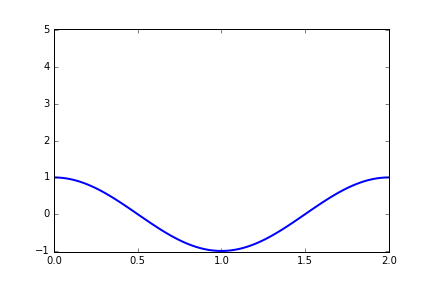
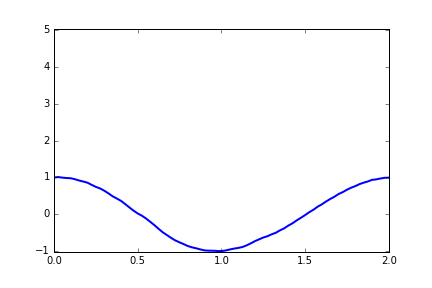
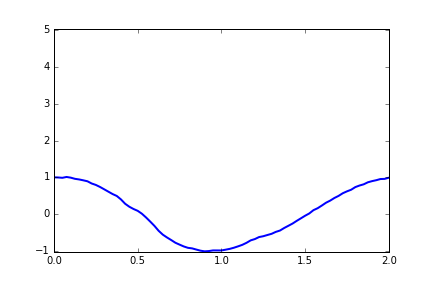
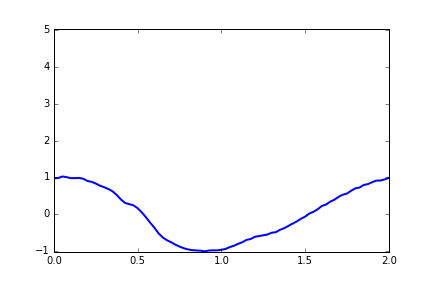
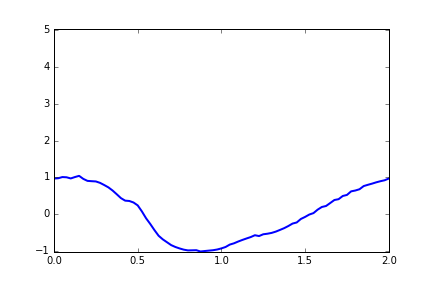
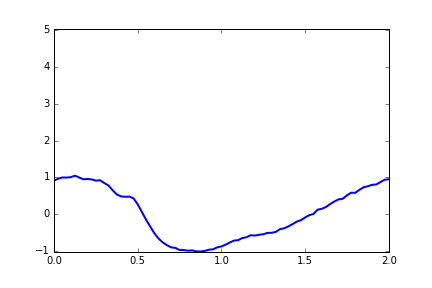
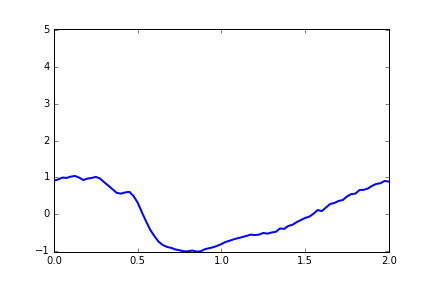
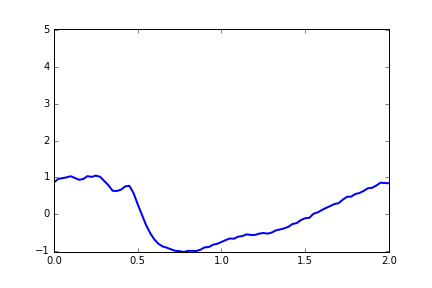
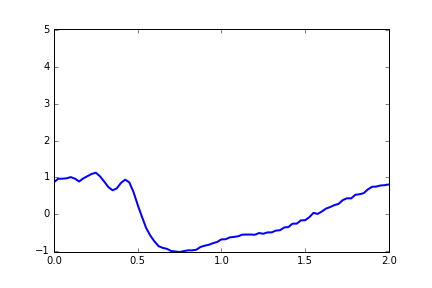
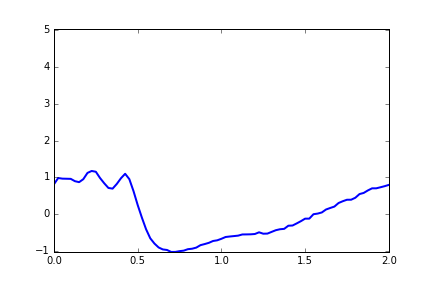
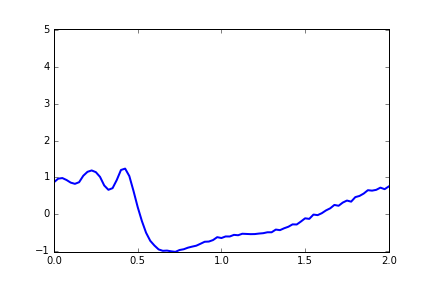
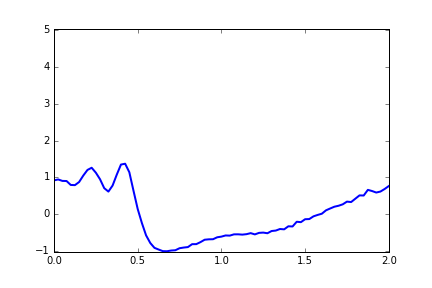
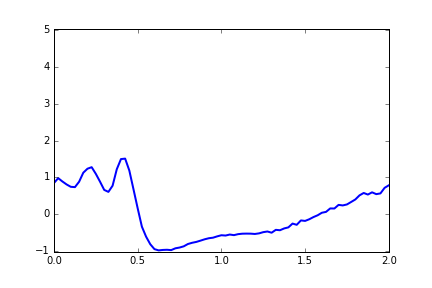
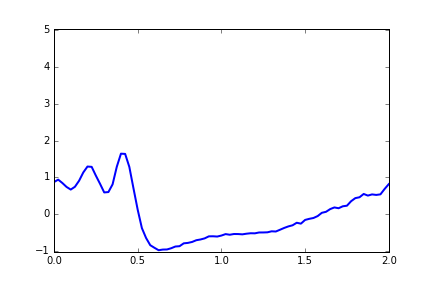
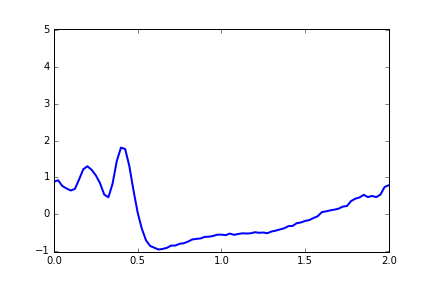
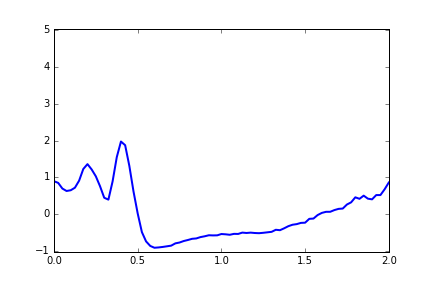
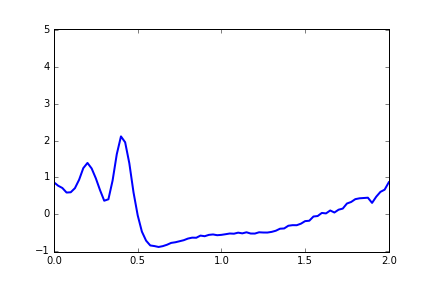
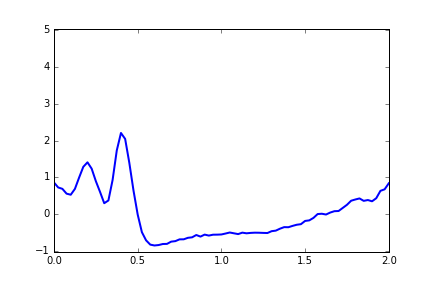
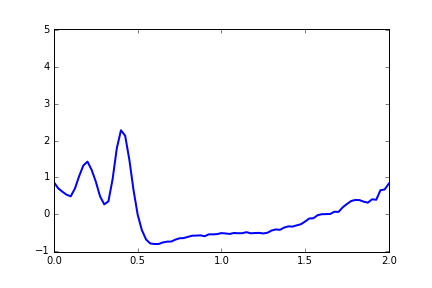
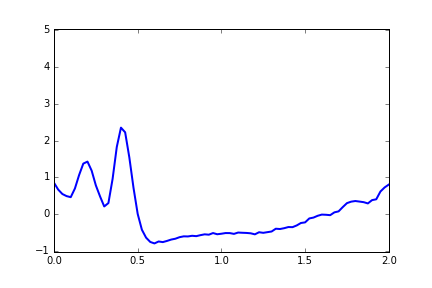
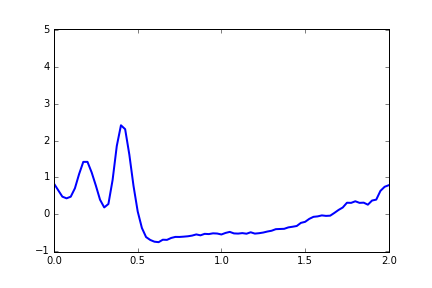
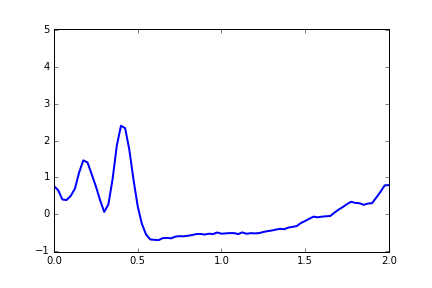
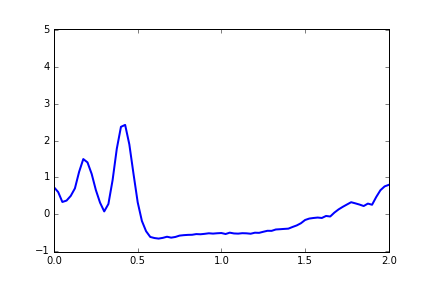
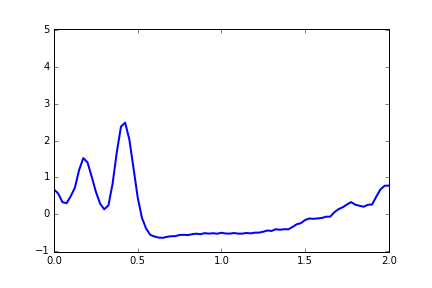
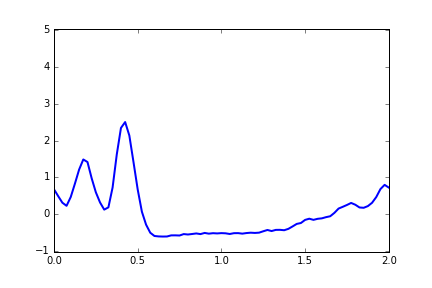
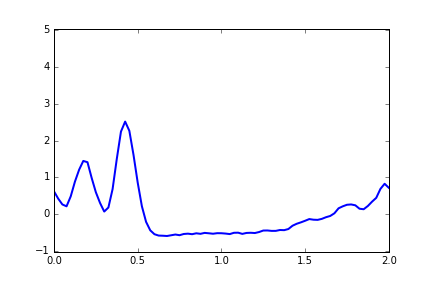
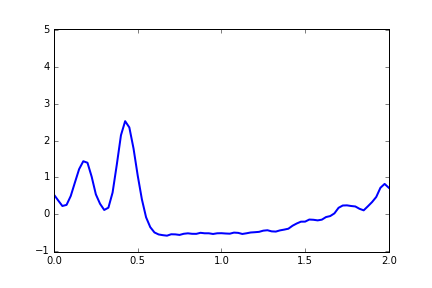
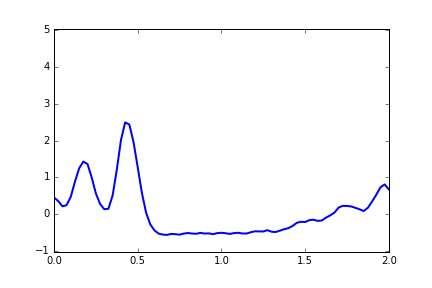
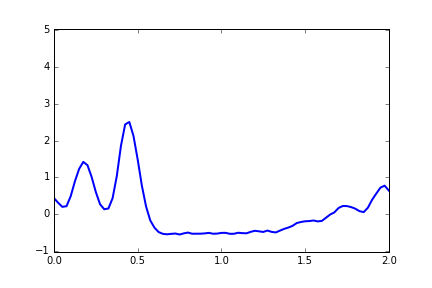
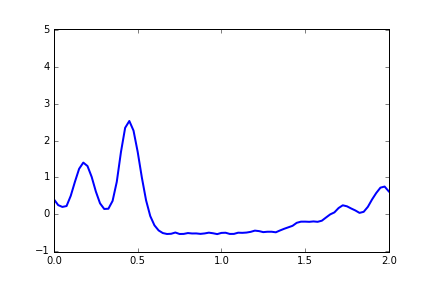
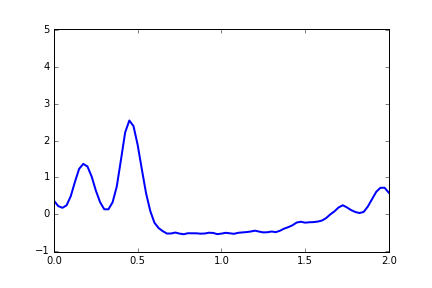
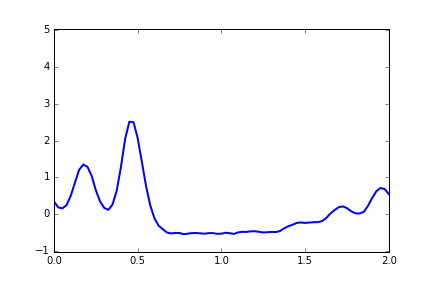
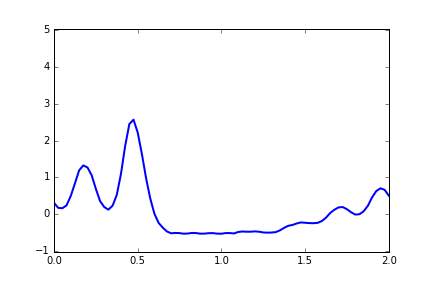
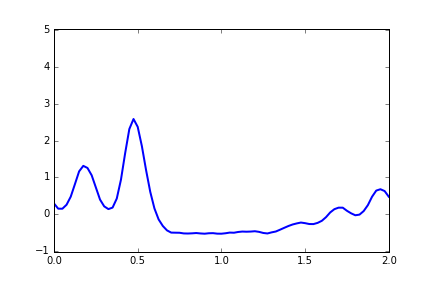
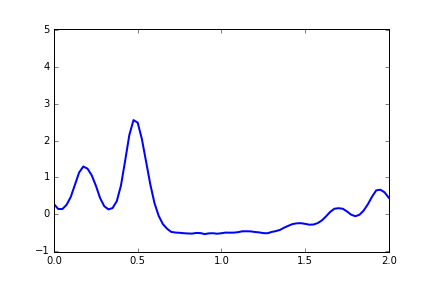
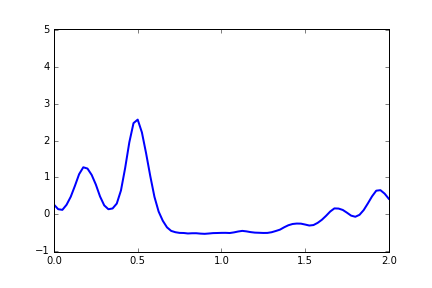
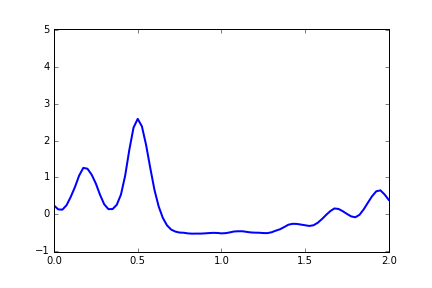
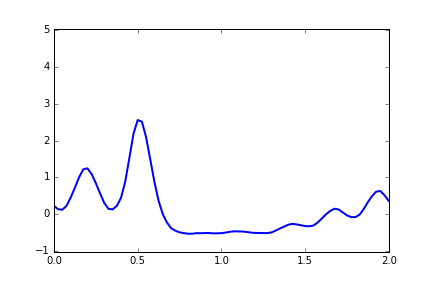
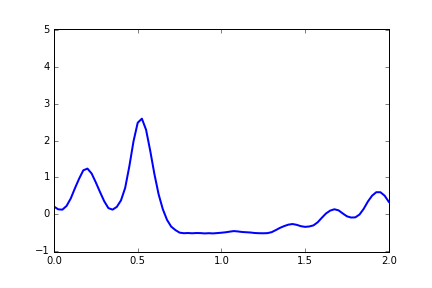
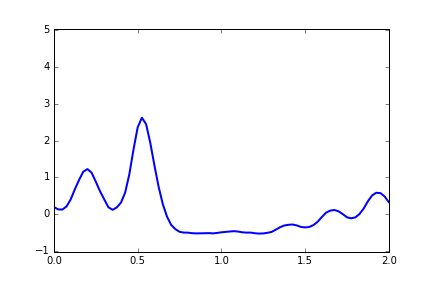
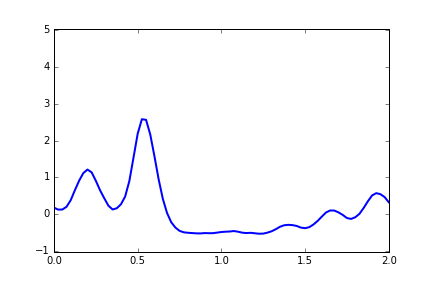
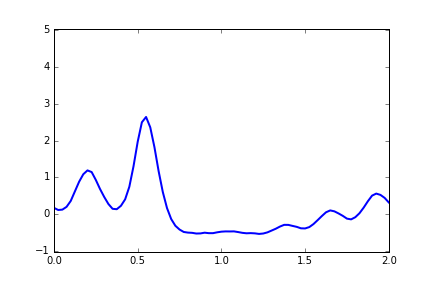
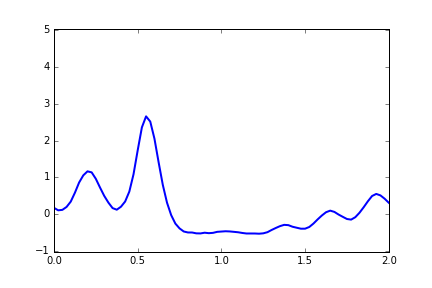
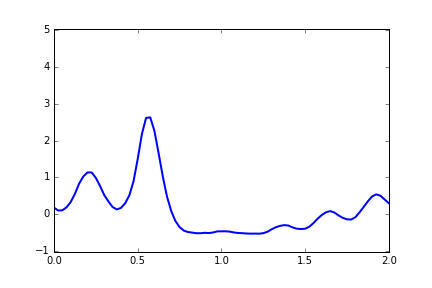
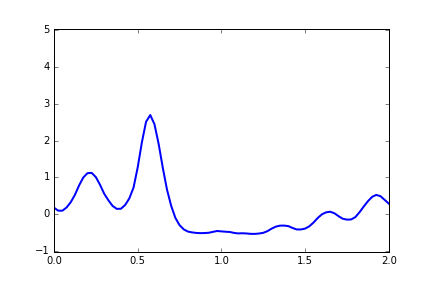
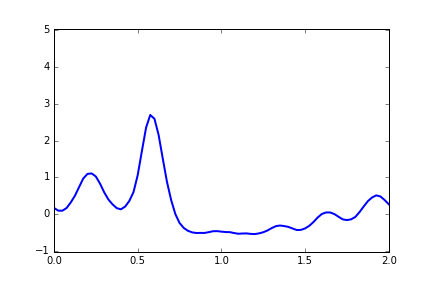
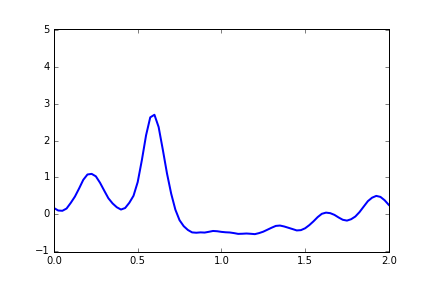
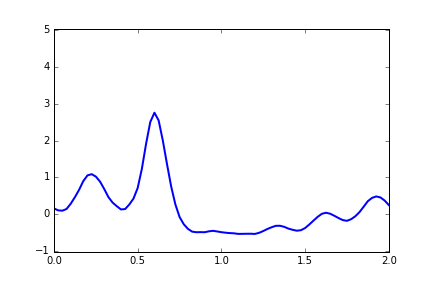
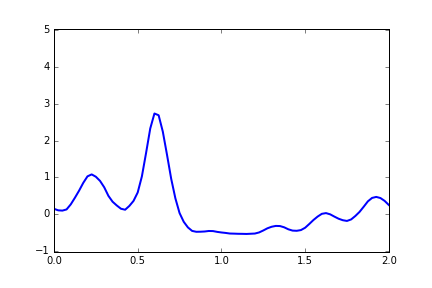
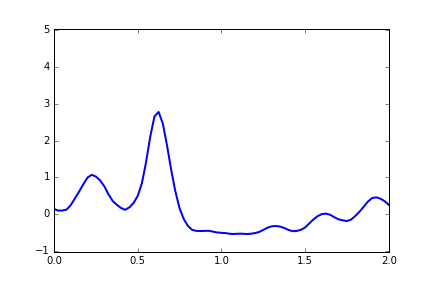
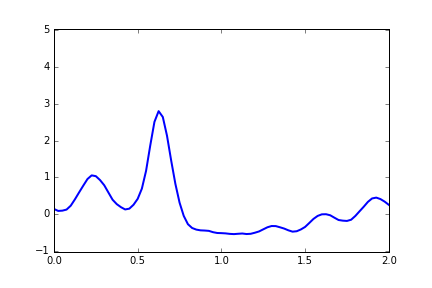
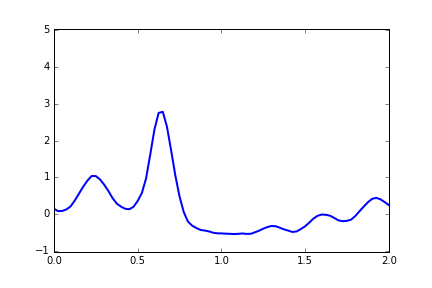
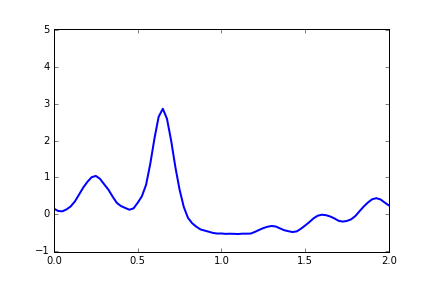
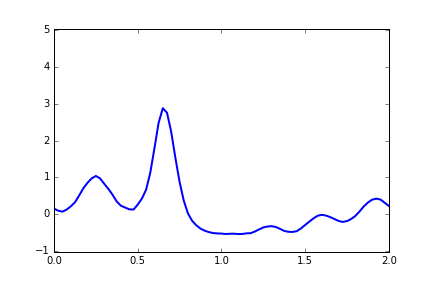
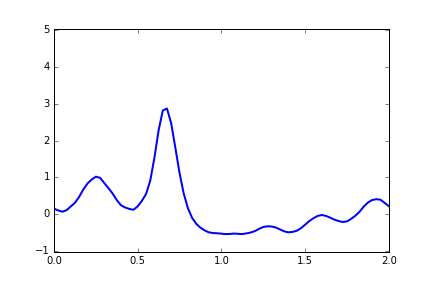
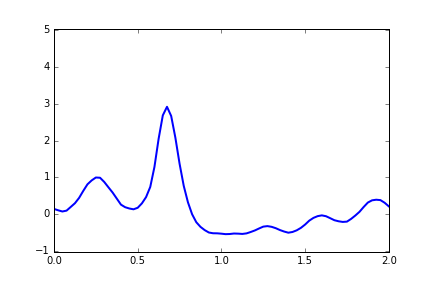
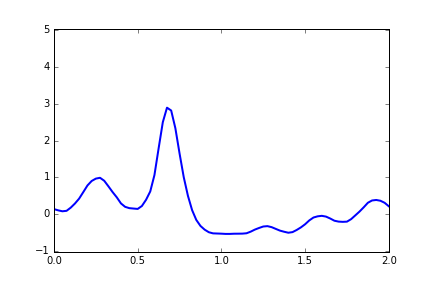
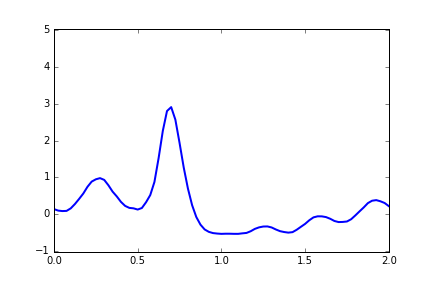
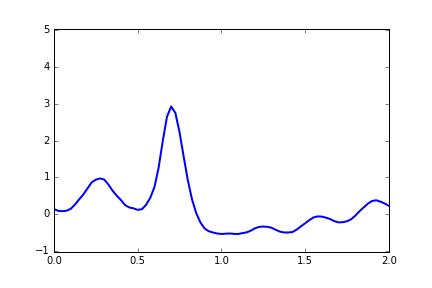
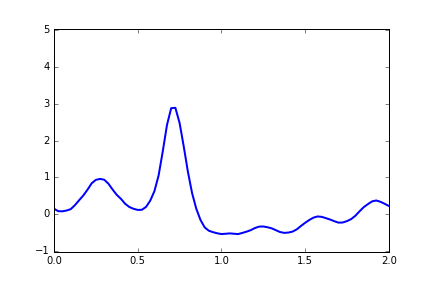
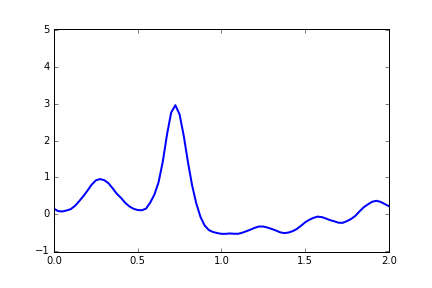
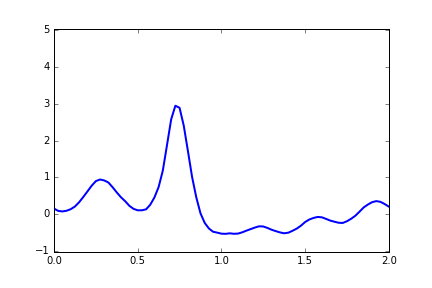
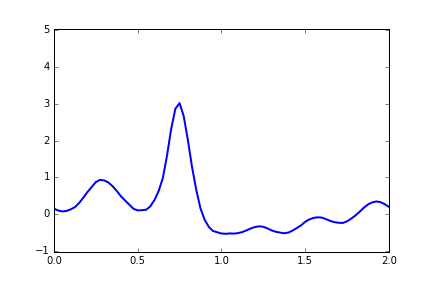
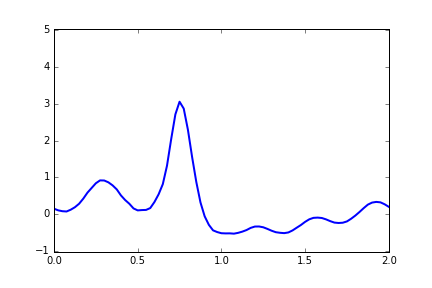
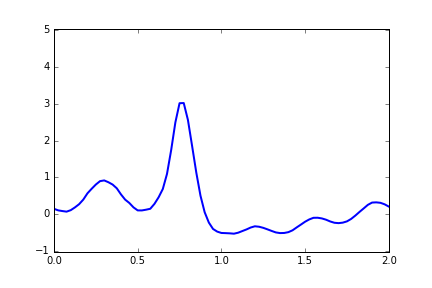
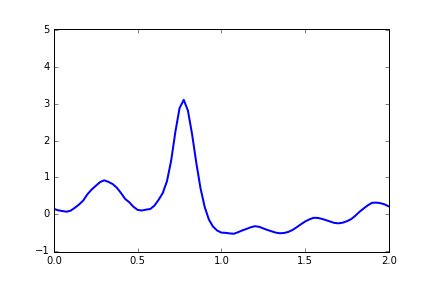
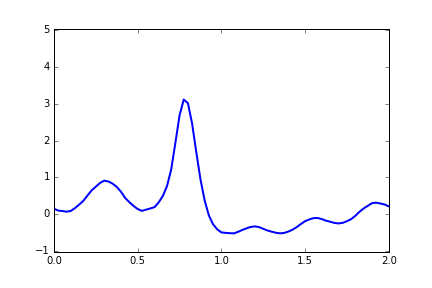
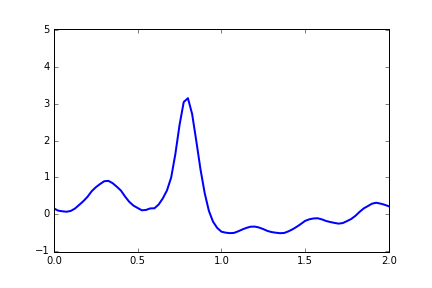
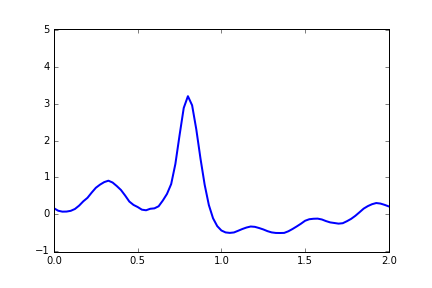
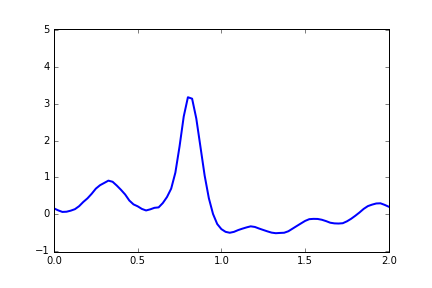
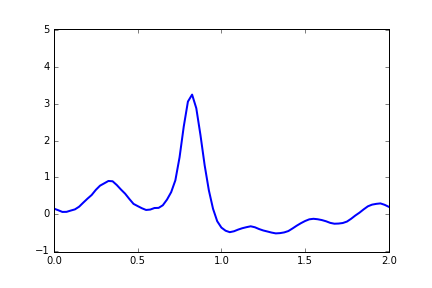
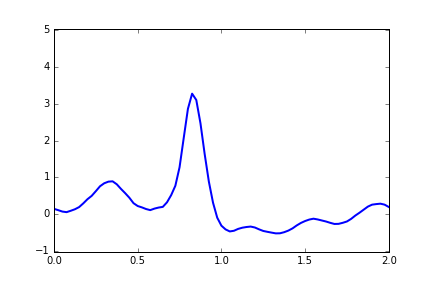
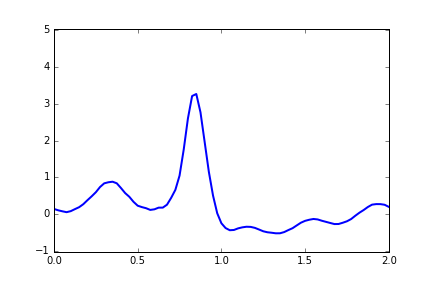
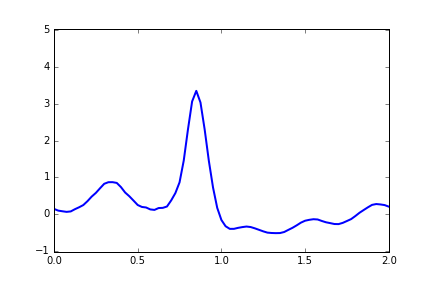
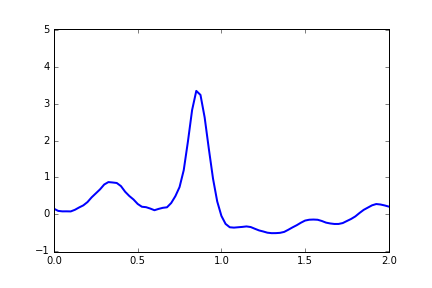
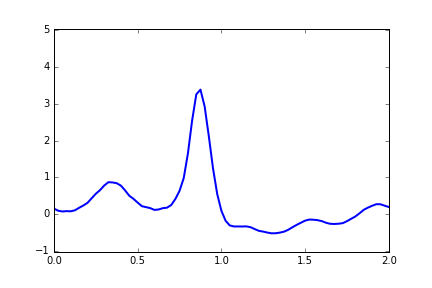
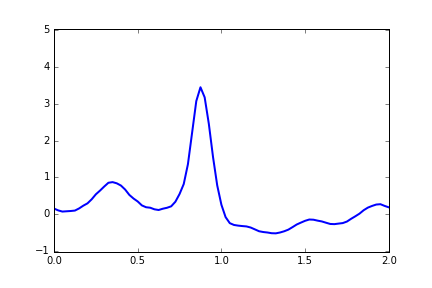
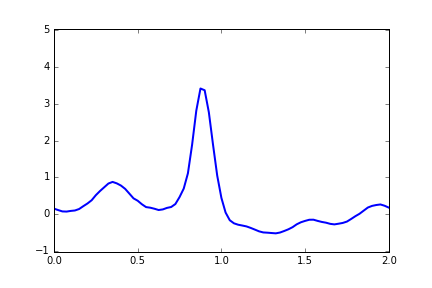
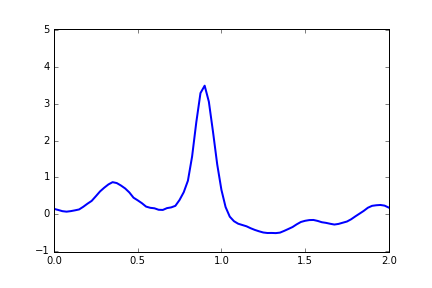
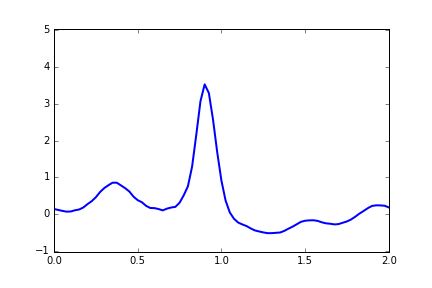
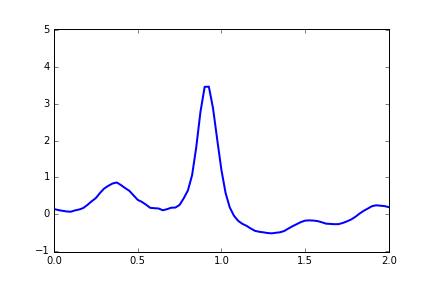
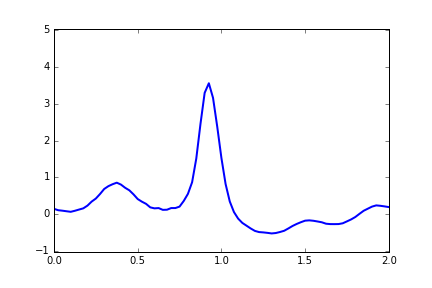
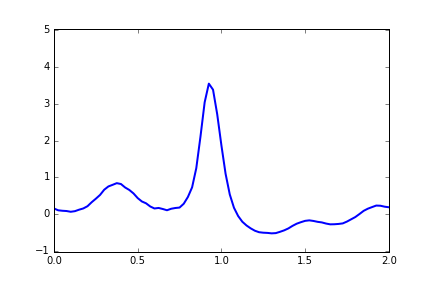
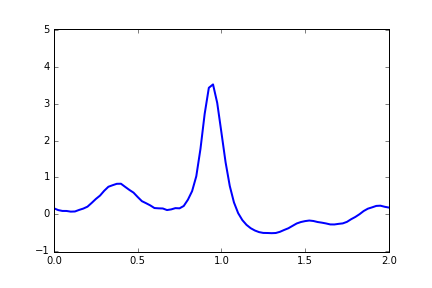
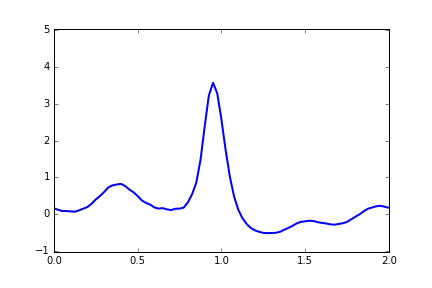
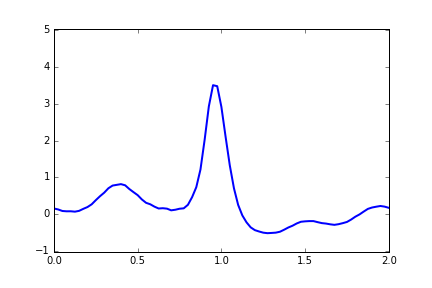
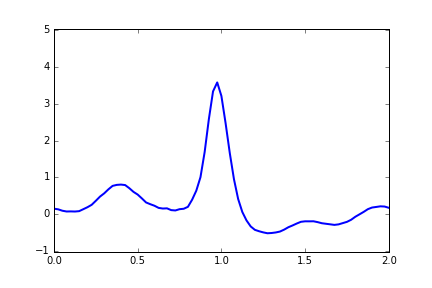
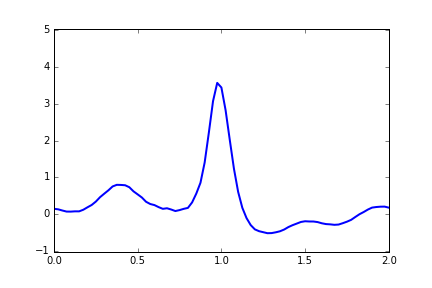
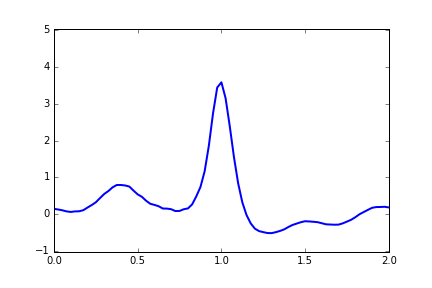
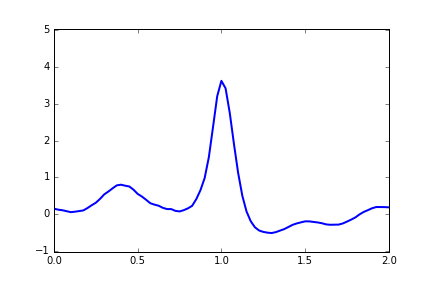
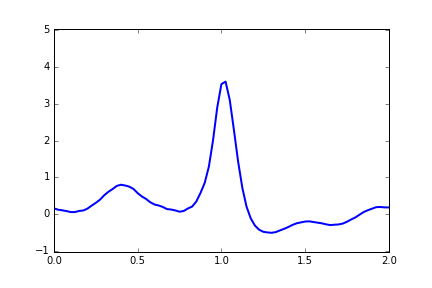
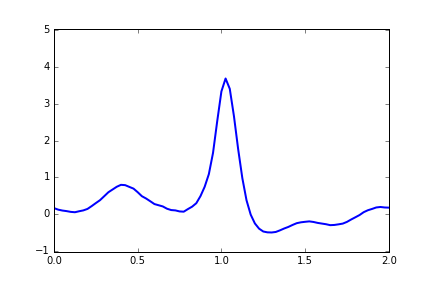
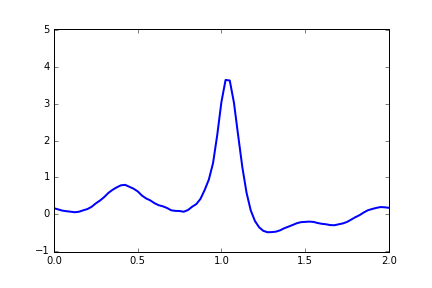
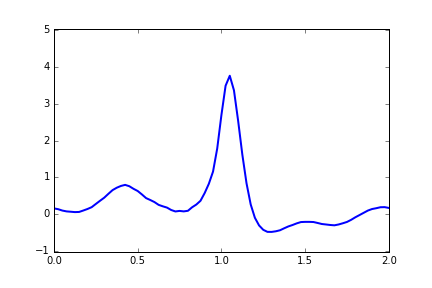
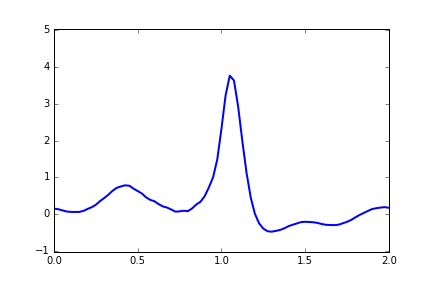
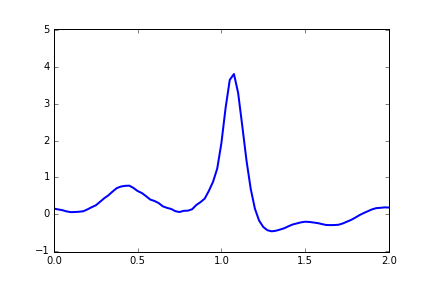
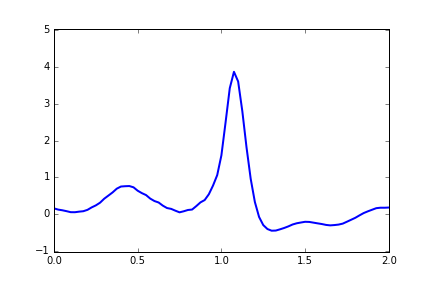
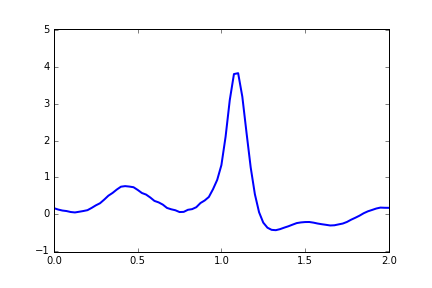
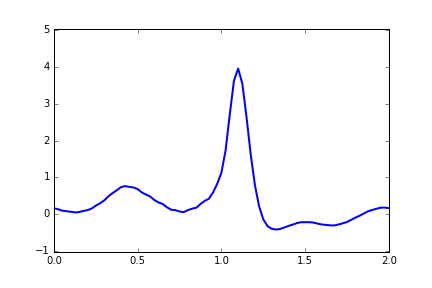
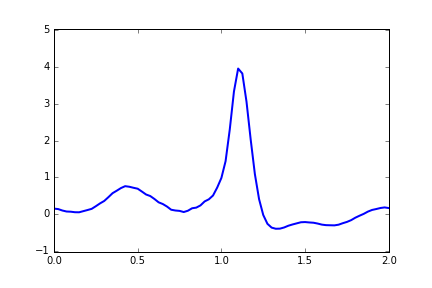
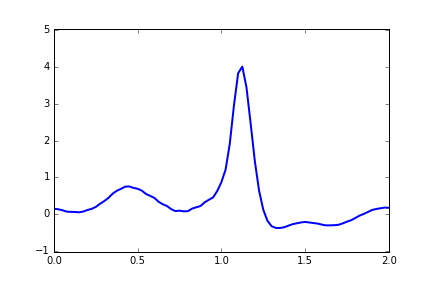
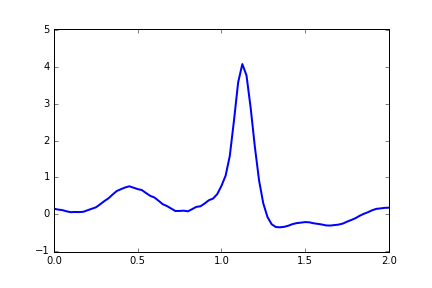
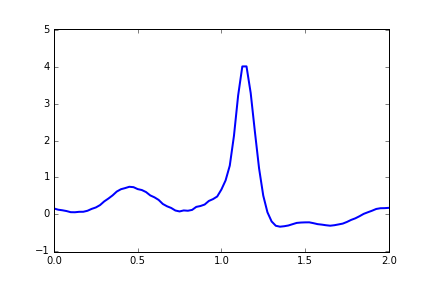
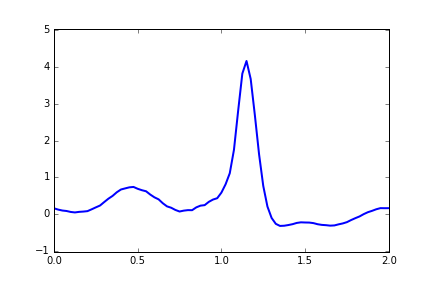
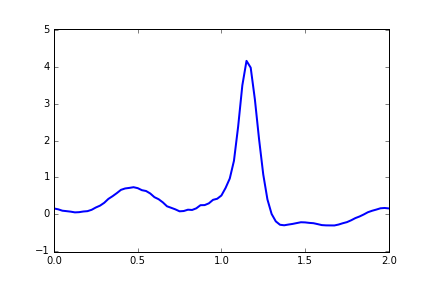
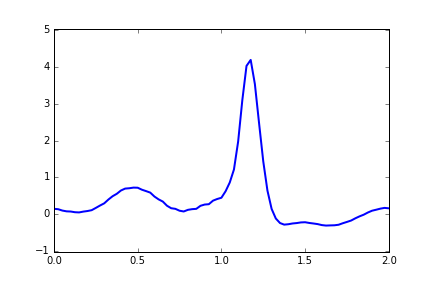
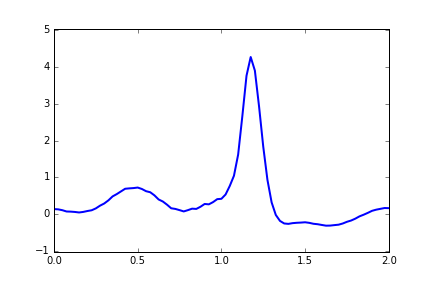
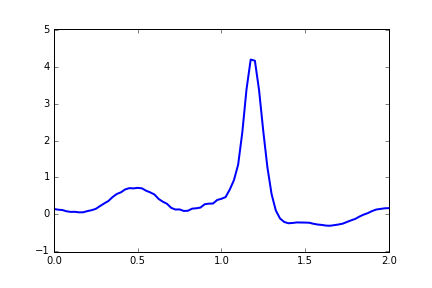
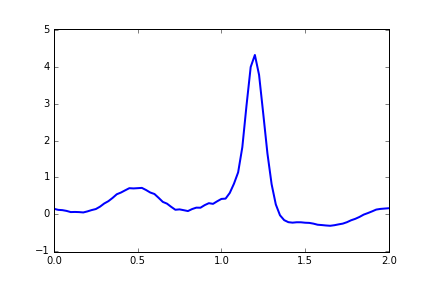
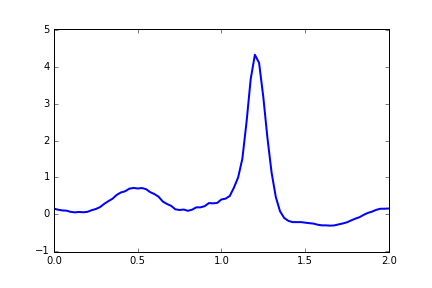
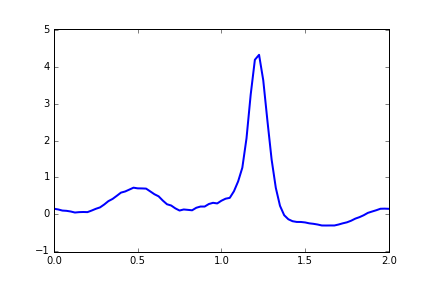
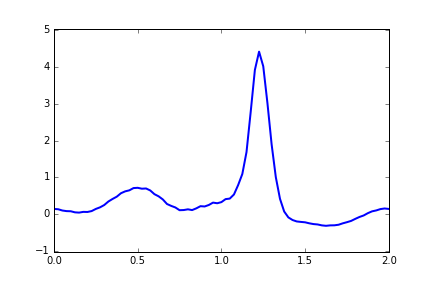
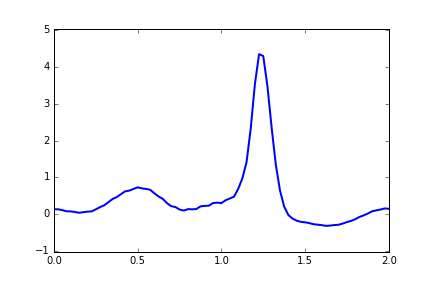
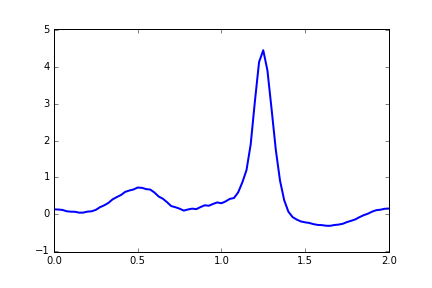
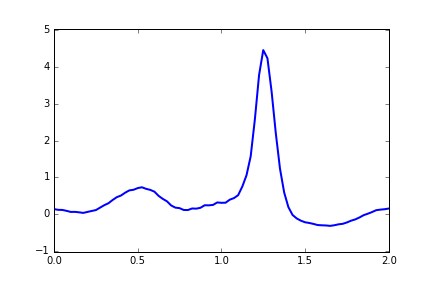
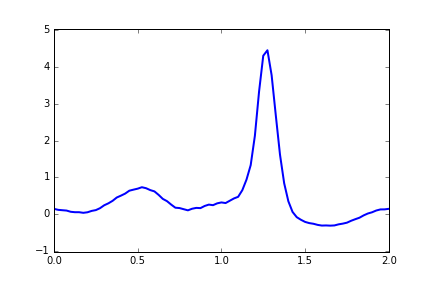
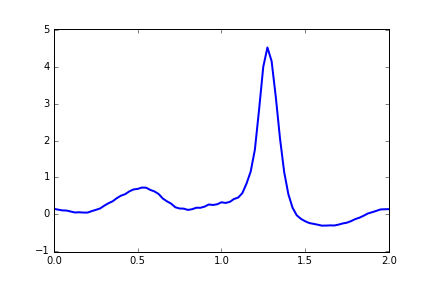
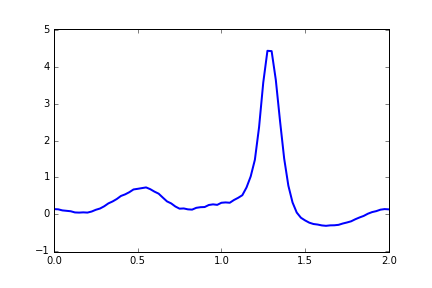
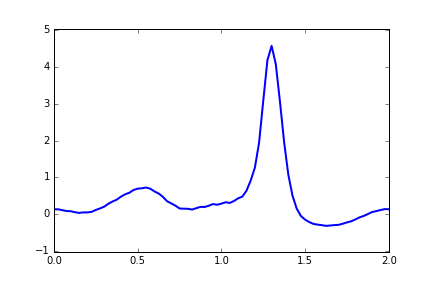
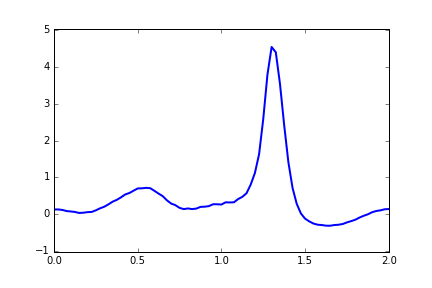
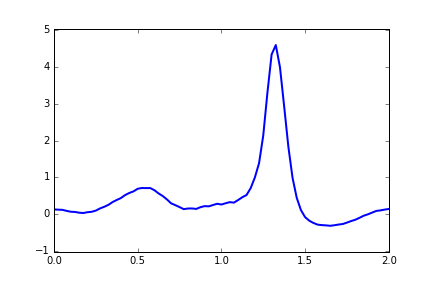
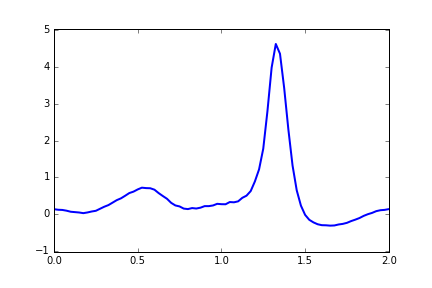
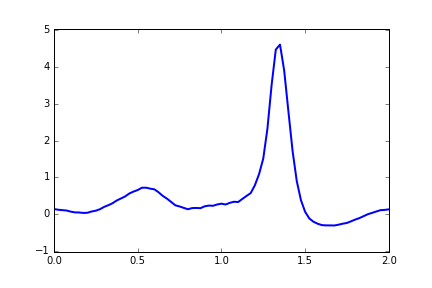
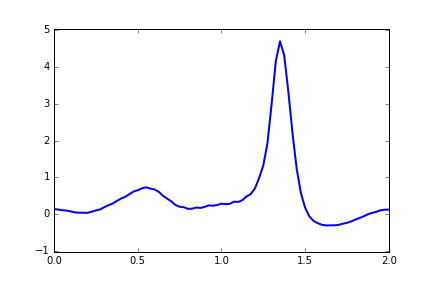
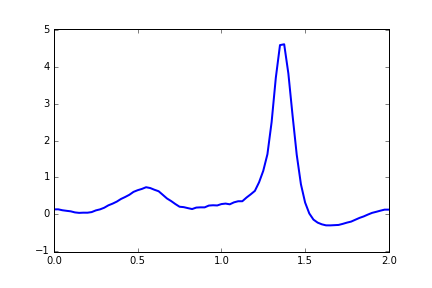
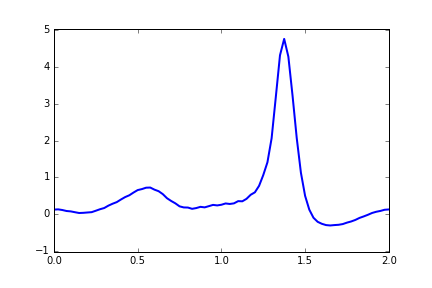
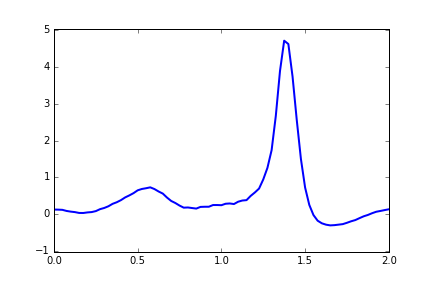
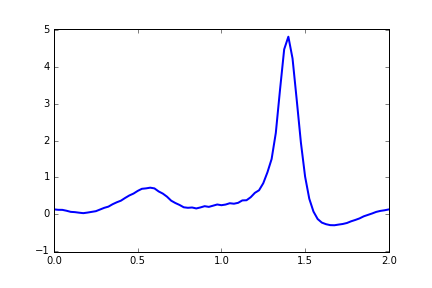
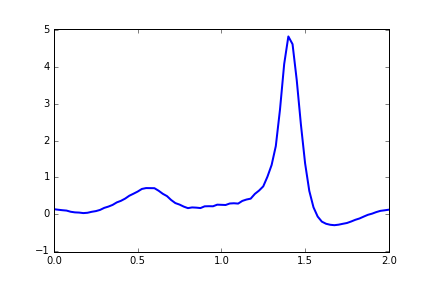
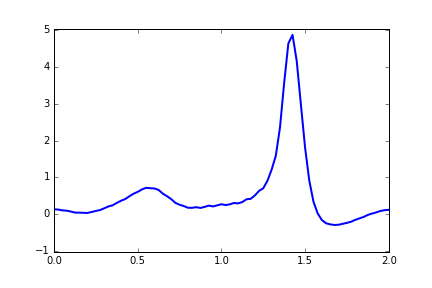
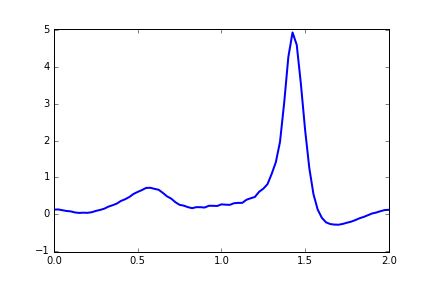

In [15]:
from matplotlib import animation
from JSAnimation import IPython_display

# ANIMATION
fig = plt.figure()
ax = plt.axes(xlim=(xmin, L), ylim=(np.amin(uall), np.amax(uall)))
line, = ax.plot([], [], lw=2)

def init():
    line.set_data([], [])
    return line,

def animate(i):
    line.set_data(x, uall[:,i])
    #ax.annotate(r'$t = %f $' %tall[i],(1,1))
    return line,

animation.FuncAnimation(fig, animate, init_func=init,
                        frames=iter-1, interval=30)